<a href="https://colab.research.google.com/github/juanrozo09/MobilePlantViT/blob/main/MobilePlantViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📒 MobilePlantViT - AI Crop Disease Detector

## 0. Environment Setup & Library Imports
---

In [ ]:
# Install optional libraries (if needed in Colab)
%pip install -q -U keras-tuner
%pip install -q -U tensorboard-plugin-profile
%pip install -q streamlit

# Reproducibility & Imports
import random, os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from datetime import datetime

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00
TF version: 2.19.0


## 1. Introduction 🌱
---

Agriculture remains the backbone of rural economies—especially in the Global South—where it employs over **65% of the workforce** in some developing regions (source: digitalplanet.tufts.edu). Yet, farmers continue to face **unpredictable losses due to pests, disease, and climate volatility**. These challenges contribute to a staggering level of food insecurity, affecting an estimated **2.3 billion people globally** (source: publicpolicy.google).

To address this, **deep learning–based diagnostic tools** offer a scalable, data-driven solution. One real-world success story is **Wadhwani AI’s pest detection app** in India, which increased farmer profits by **20%** and reduced pesticide use by **25%** by enabling timely and precise interventions (source: publicpolicy.google). This dual impact—**improved incomes and environmental benefits**—underscores the power of AI in agriculture.

In **Latin America**, the potential is equally transformative:
- A **4-year study in Colombia** showed that ML-guided recommendations based on weather and soil data boosted maize yields from **3.5 to over 6 tons per hectare**—a **~70% increase** (source: eurekalert.org).
- In Chile’s **Biobío region**, AI-powered irrigation systems led to **30% less water use** and **20% higher yields**, demonstrating efficiency gains through resource-aware agriculture (source: developmentaid.org).
- AI-guided precision spraying systems such as **AgZen**, an MIT spinoff, have reduced pesticide volumes by **30–50%** while also **increasing crop yields** via precise targeting and real-time feedback (source: news.mit.edu).

These results show that **AI-based agriculture can deliver double-digit improvements** in both yield and cost efficiency—outcomes that directly support **food security, farmer livelihoods, and environmental sustainability**.

**Project Goal:** This project presents **MobilePlantViT**, a deep learning solution designed for smallholder farmers in Latin America. It uses lightweight CNN or ViT architectures to detect plant diseases from **smartphone images**, enabling **real-time, offline diagnostics** even in low-connectivity environments.

By combining accurate classification with edge deployment, this tool could:
- Prevent crop losses from disease.
- Increase productivity by reducing treatment delay.
- Minimize overuse of agrochemicals.
- Empower millions of farmers with actionable AI.

Ultimately, this system could help unlock significant **yield and income gains**, while reducing the environmental footprint of farming.

## 2. Project Objectives 🎯
---

- Use transfer learning on the PlantVillage dataset.
- Train a lightweight CNN model optimized for mobile inference.
- Export to TensorFlow Lite for offline deployment.
- Evaluate accuracy, latency, and confusion metrics.
- Provide a working demo via Streamlit or mobile.

## 3. Dataset Loading & Preprocessing
---

This section handles loading the PlantVillage dataset and preparing it for training:

- Splits the dataset into 70% training, 15% validation, and 15% test.
- Enables mixed precision training for speed and efficiency on supported GPUs.
- Resizes images and applies MobileNetV3 preprocessing.
- Uses TensorFlow tf.data pipeline for efficient loading (caching, batching, prefetching).

In [ ]:
# Enable mixed precision (for faster training on Colab GPUs)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = (160, 160)
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Preprocess function
def format_image(image, label):
  image = tf.image.resize(image, IMG_SIZE)
  image = tf.keras.applications.mobilenet_v3.preprocess_input(tf.cast(image, tf.float32))
  return image, label

# Apply mapping, caching, batching, prefetching
def prepare(ds):
  return (ds
          .map(format_image, num_parallel_calls=AUTO)
          .shuffle(1000)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))

ds_train = prepare(ds_train)
ds_val = prepare(ds_val)
ds_test = prepare(ds_test)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.HBRPOI_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


## 4. Dataset Visualization & Class Balance
---

- Display sample images per disease category to validate labels and variability.

- Plot class distributions to check for imbalance.

- Visualize augmented samples to illustrate variability introduced.

/tmp/ipython-input-1687412333.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


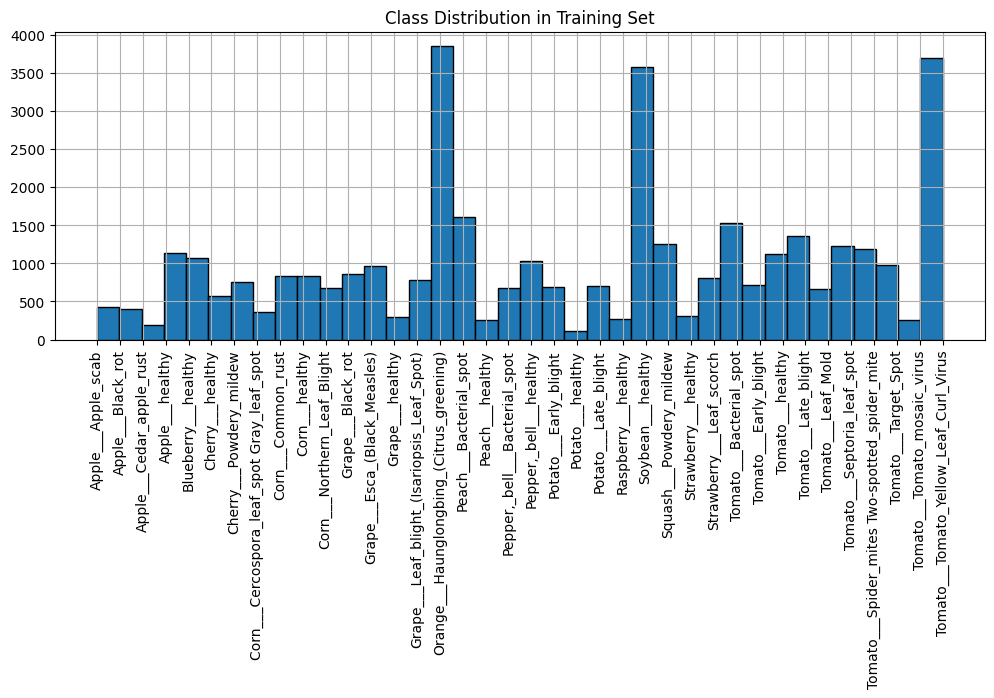

In [ ]:
class_names = ds_info.features['label'].names

# Class distribution histogram
labels = []
for _, label in tfds.as_numpy(ds_train.unbatch()):
  labels.append(label)

plt.figure(figsize=(12, 4))
plt.hist(labels, bins=len(class_names), edgecolor='k')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.title("Class Distribution in Training Set")
plt.grid(True)
plt.tight_layout()
plt.show()

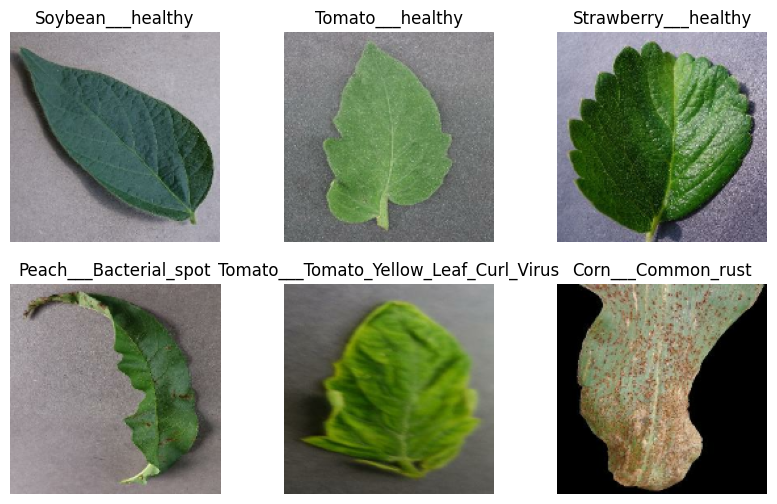

In [ ]:
# Sample images
def format_image_for_visualization(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

ds_plot = ds_train.map(format_image_for_visualization)

plt.figure(figsize=(10, 6))
for images, labels in ds_plot.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 5. Model Architecture (MobileNetV3Small)
---

Defines the CNN-based model architecture using MobileNetV3Small:

- Loads a pretrained MobileNetV3Small model with ImageNet weights as a frozen base (transfer learning).
- Applies data augmentation using TensorFlow's built-in layers to improve robustness.
- Adds a global average pooling, a dropout layer to prevent overfitting, and dense layers for classification.
- Uses softmax output with float32 precision for compatibility with mixed precision training.

This architecture is efficient and optimized for mobile deployment (TFLite-compatible).

In [ ]:
# Load pre-trained model
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.15, 0.15),
    tf.keras.layers.RandomContrast(0.1),
])

# Build final model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax', dtype='float32')  # Output must be float32 for mixed precision
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 5, 5, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,878 (3.88 MB)

 Trainable params: 78,758 (307.65 KB)

 Non-trainable params: 939,120 (3.58 MB)

## 6. Training the Model
---

Trains the model using the prepared dataset and callbacks:

- Implements TensorBoard for training logs and monitoring.
- Uses EarlyStopping to avoid overfitting by halting training if validation loss does not improve.
- Saves the best-performing model using ModelCheckpoint.
- Plots training and validation accuracy for inspection.

This step takes about 10-15 minutes on a GPU and can be monitored with `%tensorboard`.

In [ ]:
from pathlib import Path
from time import strftime

# Logging & callbacks
def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch=0)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss", restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

# Train -> 15 min
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb]
)

Epoch 1/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 63s 43ms/step - accuracy: 0.3489 - loss: 2.5973 - val_accuracy: 0.7305 - val_loss: 1.0024
Epoch 2/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - accuracy: 0.7400 - loss: 0.9603 - val_accuracy: 0.8162 - val_loss: 0.6594
Epoch 3/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.8098 - loss: 0.6638 - val_accuracy: 0.8432 - val_loss: 0.5260
Epoch 4/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.8392 - loss: 0.5519 - val_accuracy: 0.8668 - val_loss: 0.4434
Epoch 5/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.8624 - loss: 0.4754 - val_accuracy: 0.8737 - val_loss: 0.4086
Epoch 6/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.8699 - loss: 0.4314 - val_accuracy: 0.8795 - val_loss: 0.3818
Epoch 7/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.8807 - loss: 0.3951 - val_accuracy: 0.8802 - val_loss: 0.3791
Epoch 8/15
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.8850 -

## 7. Hyperparameter Tuning (Bayesian Optimization)
---

Uses Keras Tuner for automatic hyperparameter tuning with a Bayesian search strategy:

- Searches over several architecture and training options:
  - Whether to use data augmentation.
  - Whether to unfreeze the base model for fine-tuning.
  - Dropout rate and dense layer size.
  - Learning rate.
- Chooses the best model based on validation accuracy.
- Uses early stopping for regularization and TensorBoard for tracking.

This allows you to identify a higher-performing model without manual trial-and-error.

In [ ]:
import keras_tuner as kt

NUM_CLASSES = ds_info.features['label'].num_classes

def build_model(hp):
  base_model = tf.keras.applications.MobileNetV3Small(
      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
      include_top=False,
      weights='imagenet'
  )

  base_model.trainable = hp.Boolean("trainable_base_model")

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))

  if hp.Boolean("use_data_augmentation"):
      data_augmentation = tf.keras.Sequential([
          tf.keras.layers.RandomFlip("horizontal"),
          tf.keras.layers.RandomRotation(0.1),
          tf.keras.layers.RandomZoom(0.1),
      ])
      model.add(data_augmentation)

  model.add(base_model)
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(tf.keras.layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1)))
  model.add(tf.keras.layers.Dense(hp.Int("dense_units", 64, 256, step=64), activation="relu"))
  model.add(tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32"))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

class MyClassificationHyperModel(kt.HyperModel):
  def build(self, hp):
    return build_model(hp)

  def fit(self, hp, model, *args, **kwargs):
    return model.fit(*args, **kwargs)

tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(),
    objective="val_accuracy",
    seed=42,
    max_trials=10,
    alpha=1e-4,
    beta=2.6,
    overwrite=True,
    directory="bayesian_project",
    project_name="image_fine_tuning"
)

# Step 6: Run the tuner (assuming you have X_train and y_train already) -> 1.5 h
log_dir = get_run_logdir("logs/hparam_tuning/")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
tuner.search(ds_train, validation_data=ds_val, epochs=10, callbacks=[early_stopping_cb, tensorboard_cb])

Trial 10 Complete [00h 07m 34s]
val_accuracy: 0.9168917536735535

Best val_accuracy So Far: 0.9911612868309021
Total elapsed time: 01h 36m 12s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps.values)

# Evaluate
test_loss, test_acc = best_model.evaluate(ds_test)
print("Test accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 286 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters:
{'trainable_base_model': True, 'use_data_augmentation': False, 'dropout': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0001}
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.9911 - loss: 0.0293
Test accuracy: 0.9905463457107544


## 8. Evaluation & Confusion Matrix
---

Evaluates the trained model on the test dataset and analyzes its performance:

- Computes test accuracy using unseen data.
- Uses sklearn to generate a confusion matrix to visualize which classes are being confused.
- Generates a detailed classification report (precision, recall, F1-score).
- Saves the metrics to a CSV for future reference.

These metrics help assess model generalization and guide further fine-tuning.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

In [ ]:
# Get one batch (a tuple of (images, labels)), each item yielded by ds_test is a batch, meaning a tuple: (images, labels)
for images, labels in ds_test.take(1):
    image = images[0]
    label = labels[0]
    break

img_batch = tf.expand_dims(image, axis=0)  # shape becomes (1, 224, 224, 3)
pred = best_model.predict(img_batch)  # shape becomes (1, 10)
predicted_class = np.argmax(pred, axis=1)[0]

class_names = ds_info.features['label'].names
print("Predicted:", class_names[predicted_class])
print("True label:", class_names[label.numpy()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: Corn___healthy
True label: Corn___healthy


255/255 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9913 - loss: 0.0286
✅ Test Accuracy: 99.05%


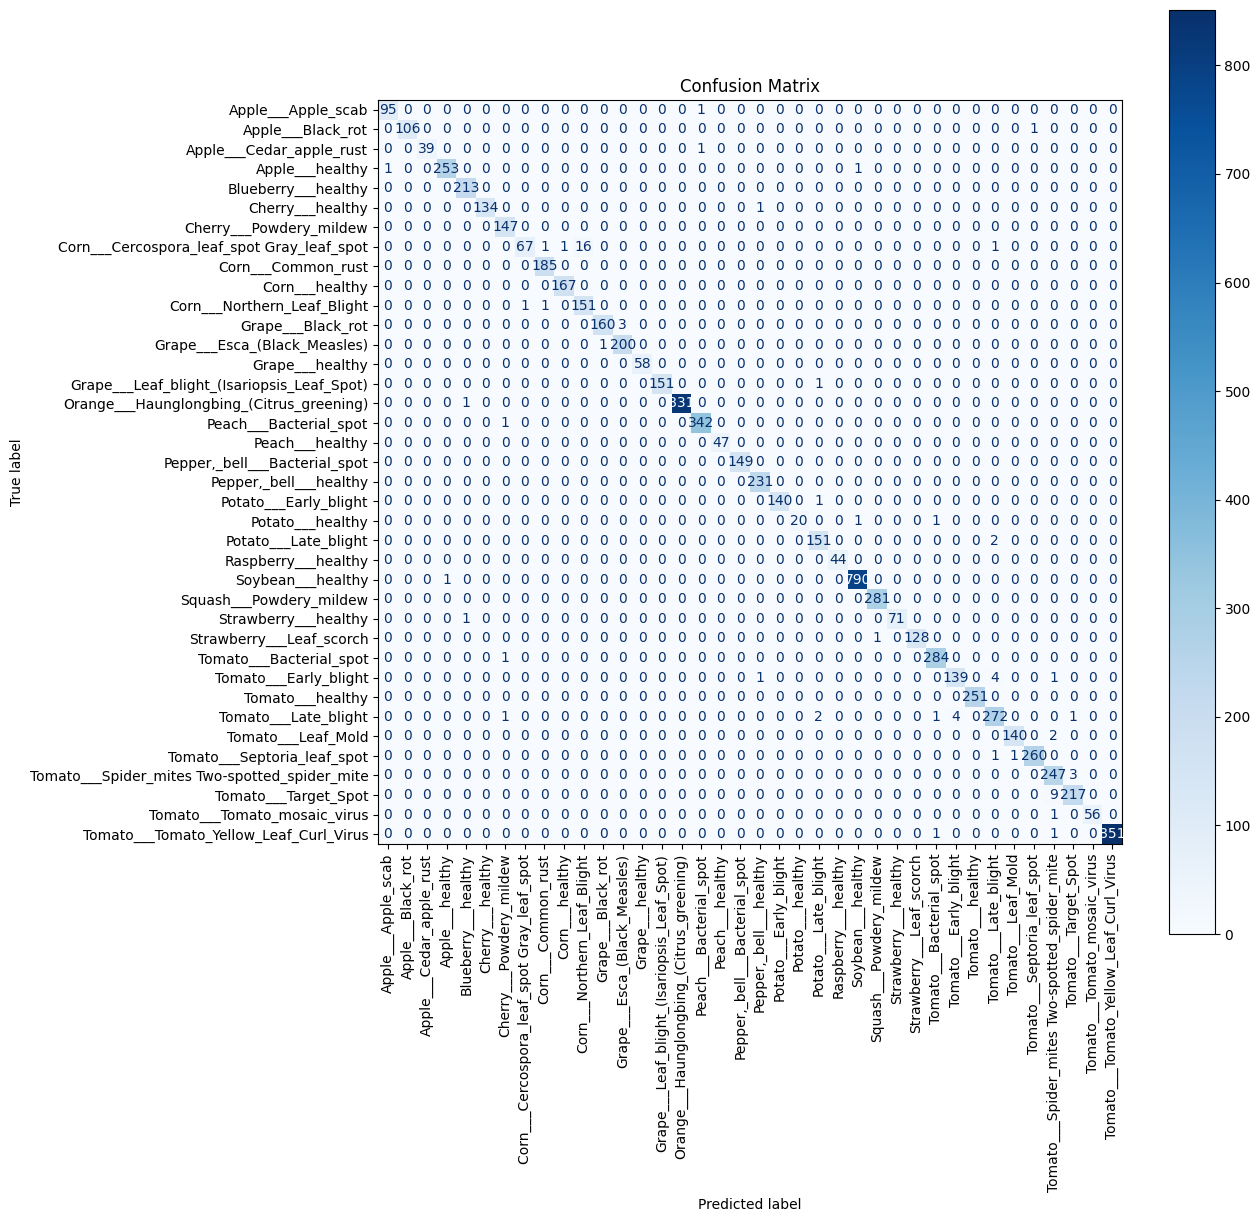

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

# Evaluate
test_loss, test_acc = best_model.evaluate(ds_test)
print(f"✅ Test Accuracy: {test_acc:.2%}")

# Predict on test set
y_true, y_pred = [], []
for images, labels in ds_test:
    preds = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
df_report = pd.DataFrame(classification_report(y_true, y_pred, target_names=class_names, output_dict=True)).T
df_report

,precision,recall,f1-score,support
Apple___Apple_scab,0.989583,0.989583,0.989583,96.000000
Apple___Black_rot,1.000000,0.990654,0.995305,107.000000
Apple___Cedar_apple_rust,1.000000,0.975000,0.987342,40.000000
Apple___healthy,0.996063,0.992157,0.994106,255.000000
Blueberry___healthy,0.990698,1.000000,0.995327,213.000000
Cherry___healthy,1.000000,0.992593,0.996283,135.000000
Cherry___Powdery_mildew,0.980000,1.000000,0.989899,147.000000
Corn___Cercospora_leaf_spot Gray_leaf_spot,0.985294,0.779070,0.870130,86.000000
Corn___Common_rust,0.989305,1.000000,0.994624,185.000000
Corn___healthy,0.994048,1.000000,0.997015,167.000000


## 9. Model Export for Deployment (TFLite)
---

Converts the best model to a TensorFlow Lite (.tflite) format:

- This format is optimized for deployment on Android and edge devices.
- The converter also applies post-training quantization to reduce model size and latency.

The result is a compact model suitable for mobile inference with offline capabilities.

In [ ]:
# Save model
# best_model.save('best_model_tuned.keras')

# Load model
best_model = tf.keras.models.load_model(
    'best_model_tuned.keras',
    custom_objects=None,
    compile=True,
    safe_mode=True
)

# Export to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('crop_disease_model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpv090tsrg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  132519013270160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013271696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013272656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013272272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013272464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013272848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013273616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013274576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013274192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013273424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132519013274

## 10. Streamlit Inference UI
---

Creates a simple web app using Streamlit:

- Loads the trained Keras model.
- Allows the user to upload an image of a leaf.
- Displays the predicted class and confidence score.

This can be run locally with `streamlit run streamlit_app.py.`

In [ ]:
# Save this as streamlit_app.py and run with `streamlit run streamlit_app.py`
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model("best_model_tuned.keras")
class_names = ds_info.features['label'].names

st.title("🌿 AI Crop Disease Detector")
uploaded_file = st.file_uploader("Upload a crop leaf image", type=["jpg", "png"])

if uploaded_file:
  image = Image.open(uploaded_file).resize((160, 160))
  img_array = np.expand_dims(np.array(image) / 255.0, axis=0)
  prediction = model.predict(img_array)
  pred_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction) * 100
  st.success(f"Prediction: {pred_class} ({confidence:.2f}%)")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 290 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 286 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-08-14 00:44:04.932 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 00:44:05.076 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-14 00:44:05.077 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in 

## 11. Conclusion & Future Work
---

- Project impact: offers an offline-capable, AI-driven diagnostic tool for crop diseases with potential to reduce yield losses, promote sustainable farming, and improve smallholder livelihoods.

- Extension ideas:

  - Fine-tune on region-specific diseases and crops.
  - Incorporate active learning to allow users to submit new disease samples.
  - Add local language advisory and treatment suggestions.
  - Deploy fully on-device via Android app or integrate into field extension workflows.

- Research relevance: aligned with global efforts to use deep learning for crop protection—where lightweight models like EfficientNetB0 and MobileViT outperform heavier nets with strong generalizability and mobile suitability

In [3]:
from google.colab import drive
drive.mount('/content/drive')  # if you want to save it in Drive

Mounted at /content/drive


In [4]:
import nbformat
path = "/content/drive/MyDrive/AI/DL/MobilePlantViT.ipynb"  # adjust to your file path

with open(path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

with open(path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print(f"✅ Cleaned widget metadata in {path}")

✅ Cleaned widget metadata in /content/drive/MyDrive/AI/DL/MobilePlantViT.ipynb


*Juan Esteban Rozo Urbina | Bogota, Colombia* 🇨🇴